## Cassandra: python driver y consultas/gráficas

In [231]:
%config IPCompleter.greedy=True
%matplotlib inline
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Configuración de la sesión, conectores y funciones auxiliares
Para permitir realizar conexiones y consultas de forma genérica hemos implementado un conjunto de funciones
auxiliares. 

* La función *get_session* encapsula la conexión sobre nuestro "keyspace" generando el objeto Session característico del conector de cassandra.

* La función *q* es una abreviatura de *query* y permite acondicionar la realización de consultas y parametrizar valores sobre ellas. El resultado es un objeto tipo *data frame*, por lo cual estaría totalmente adaptado al entorno y sin necesidad de ser característico para el tipo de conector o base de datos.

```
session = get_session("espaciodatos")
q(session, "select * from incidents where incidentId = {id}", id = 10)
```

In [376]:
def get_session(keyspace):
    """Obtiene el conector con la sesión actual al keyspace indicado."""
    return (Cluster(['127.0.0.1']).connect(keyspace))

def q(session, query, **kwargs):
    """Función auxiliar para encapsular las queries producidas por cassandra en formato dataframe."""
    return pd.DataFrame([row for row in session.execute(query.format(**kwargs))])

conn = get_session("incidents")


#### Funciones auxiliares
Las siguientes funciones auxiliares son necesarias para agilizar el tratamiento de las consultas sobre todo en la parte de parametrización.

In [345]:

def nowOrdate(date=None):
    """Función auxiliar para permitir un valor por defecto en el timestamp de las queries 
    si no se introduce un valor válido. Por defecto devuelve la fecha actual como timestamp.
    """
    return "dateof(now())" if (date is None) else "'" + date+" 00:00:00'"

def eqOrInIntegers(obj=None):
    """Función que obtiene el operator = o in junto con los valores
    dependiendo si el objeto es una lista o no."""
    return None if obj is None else "in ("+",".join(str(x) for x in obj) + ")" if isinstance(obj, list) else "=" + str(obj)

def eqOrIn(obj=None):
    """Función que obtiene el operator = o in junto con los valores
    dependiendo si el objeto es una lista o no."""
    return None if obj is None else "in ('"+"','".join(str(x) for x in obj) + "')" if isinstance(obj, list) else "='" + obj + "'"
    

#### Testeando las funciones auxiliares

In [301]:
[nowOrdate("2014-01-01"), nowOrdate()]

["'2014-01-01 00:00:00'", 'dateof(now())']

In [306]:
[eqOrIn("categoria1"), eqOrIn(["calle1","calle2"]) ,eqOrIn()]

["='categoria1'", "in ('calle1','calle2')", None]

In [346]:
[eqOrInIntegers(2015),eqOrInIntegers([2015,2016])]

['=2015', 'in (2015,2016)']

## Vistas
A continuación mostraremos todas las funciones necesarias para obtener cada una de las vistas
de las consultas analizadas en la fase I:

* ### Obtener incidencias (general)

  * Obtener total de actividad criminal _(getIncidents)_
  * Búsqueda de incidencia _(getIncident)_
  * Búsqueda de incidencias en un rango/periodo de tiempo _(getIncidentsByDate)_



In [315]:
def getIncidents(session, limit = 100):
    return q(session, "select * from incidents.overall limit {limit}",limit=limit)

def getIncident(session, incidentId=None):
    return q(session, "select * from incidents.overall where incidentId={id}",id=incidentId)

def getIncidentsByDate(session, limit = 100, since="2014-01-01", to=None, year=2015):
    print(nowOrdate(since), nowOrdate(to))
    return q(session, "select * from incidents.overall " +
                      "where time >= {since} and time <= {to} and year = {year} allow filtering;",
                     year=year,since=nowOrdate(since), to=nowOrdate(to), limit = limit)

**Ejemplo: ** Obtener la actividad criminal denominado con el identificador 140009459

In [232]:
getIncident(conn, incidentId = 140009459)

,year,time,incidentid,subid,address,category,day,dayoftheweek,description,district,hour,location,month,resolution,x,y
0,2014,2014-01-04 03:52:00,140009459,14000945926030,SACRAMENTO ST / POLK ST,ARSON,4,Saturday,ARSON,NORTHERN,3,"(37.7914943051906, -122.420874632415)",1,"ARREST, BOOKED",-122.420874632415,37.7914943051906


**Ejemplo: ** Obtener la actividad criminal en general (límite de 5 filas)

In [317]:
getIncidents(conn, limit=5)

,year,time,incidentid,subid,address,category,day,dayoftheweek,description,district,hour,location,month,resolution,x,y
0,2014,2014-01-04 03:52:00,140009459,14000945926030,SACRAMENTO ST / POLK ST,ARSON,4,Saturday,ARSON,NORTHERN,3,"(37.7914943051906, -122.420874632415)",1,"ARREST, BOOKED",-122.420874632415,37.7914943051906
1,2015,2015-02-04 20:27:00,150098577,15009857763010,800 Block of BRYANT ST,WARRANTS,4,Wednesday,WARRANT ARREST,SOUTHERN,20,"(37.775420706711, -122.403404791479)",2,"ARREST, BOOKED",-122.403404791479,37.775420706711
2,2015,2015-02-01 20:35:00,150098997,15009899716010,700 Block of MARKET ST,DRUG/NARCOTIC,1,Sunday,POSSESSION OF MARIJUANA,SOUTHERN,20,"(37.7871160984672, -122.403919148357)",2,NONE,-122.403919148357,37.7871160984672
3,2015,2015-02-01 20:35:00,150098997,15009899703414,700 Block of MARKET ST,ROBBERY,1,Sunday,ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE,SOUTHERN,20,"(37.7871160984672, -122.403919148357)",2,NONE,-122.403919148357,37.7871160984672
4,2015,2015-02-01 20:30:00,150098969,15009896903074,PALOU AV / QUINT ST,ROBBERY,1,Sunday,"ROBBERY, BODILY FORCE",BAYVIEW,20,"(37.7371564713337, -122.396516726913)",2,NONE,-122.396516726913,37.7371564713337


**Ejemplo: ** Obtener la actividad criminal desde el 2 Enero del 2015 (límite de 5 filas)

In [316]:
getIncidentsByDate(conn, since="2015-01-02", limit = 5)

'2015-01-02 00:00:00' dateof(now())


,year,time,incidentid,subid,address,category,day,dayoftheweek,description,district,hour,location,month,resolution,x,y
0,2015,2015-02-04 20:27:00,150098577,15009857763010,800 Block of BRYANT ST,WARRANTS,4,Wednesday,WARRANT ARREST,SOUTHERN,20,"(37.775420706711, -122.403404791479)",2,"ARREST, BOOKED",-122.403404791479,37.775420706711
1,2015,2015-02-01 20:35:00,150098997,15009899716010,700 Block of MARKET ST,DRUG/NARCOTIC,1,Sunday,POSSESSION OF MARIJUANA,SOUTHERN,20,"(37.7871160984672, -122.403919148357)",2,NONE,-122.403919148357,37.7871160984672
2,2015,2015-02-01 20:35:00,150098997,15009899703414,700 Block of MARKET ST,ROBBERY,1,Sunday,ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE,SOUTHERN,20,"(37.7871160984672, -122.403919148357)",2,NONE,-122.403919148357,37.7871160984672
3,2015,2015-02-01 20:30:00,150098969,15009896903074,PALOU AV / QUINT ST,ROBBERY,1,Sunday,"ROBBERY, BODILY FORCE",BAYVIEW,20,"(37.7371564713337, -122.396516726913)",2,NONE,-122.396516726913,37.7371564713337
4,2015,2015-02-01 20:26:00,150098975,15009897564020,1300 Block of REVERE AV,NON-CRIMINAL,1,Sunday,"AIDED CASE, MENTAL DISTURBED",BAYVIEW,20,"(37.728979731984, -122.385545453301)",2,NONE,-122.385545453301,37.728979731984
5,2015,2015-02-01 20:15:00,150098953,15009895304134,1000 Block of GOETTINGEN ST,ASSAULT,1,Sunday,BATTERY,INGLESIDE,20,"(37.7190699683467, -122.403249637246)",2,"ARREST, BOOKED",-122.403249637246,37.7190699683467
6,2015,2015-02-01 20:00:00,150098947,15009894728160,3400 Block of 16TH ST,VANDALISM,1,Sunday,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",MISSION,20,"(37.7643418581632, -122.430494795393)",2,"ARREST, BOOKED",-122.430494795393,37.7643418581632
7,2015,2015-02-01 20:00:00,150098947,15009894727170,3400 Block of 16TH ST,OTHER OFFENSES,1,Sunday,RESISTING ARREST,MISSION,20,"(37.7643418581632, -122.430494795393)",2,"ARREST, BOOKED",-122.430494795393,37.7643418581632
8,2015,2015-02-01 20:00:00,150098947,15009894726210,3400 Block of 16TH ST,ASSAULT,1,Sunday,THREATENING SCHOOL OR PUBLIC EMPLOYEE,MISSION,20,"(37.7643418581632, -122.430494795393)",2,"ARREST, BOOKED",-122.430494795393,37.7643418581632
9,2015,2015-02-01 20:00:00,150098947,15009894719090,3400 Block of 16TH ST,DRUNKENNESS,1,Sunday,UNDER INFLUENCE OF ALCOHOL IN A PUBLIC PLACE,MISSION,20,"(37.7643418581632, -122.430494795393)",2,"ARREST, BOOKED",-122.430494795393,37.7643418581632



* ### Obtener actividad criminal **por zona**

  * Obtener total de actividad criminal por distrito _(getCountByDistrict)_
  * Obtener actividad criminal agrupado por distrito/año _(getByDistrict)_



In [355]:

def getCountByDistrict(session, limit = 100, year=2015):
    return q(session, "select district, count(*) " +
                      "from incidents.bydistrict " +
                      "where year {eqyear} " +
                      "group by district limit {limit}; ", eqyear = eqOrInIntegers(year), limit = limit)

def getByDistrict(session, limit = 100, year=2015, district=None):
    return q(session, "select district, year, incidentid, category, time, location " +
                      "from incidents.bydistrict where year={year} " +
                      (" " if district is None else "and district={district} ") + 
                      "limit {limit}", year=year, limit=limit, district= district)

**Ejemplos:** Obtener numero de incidencias por distrito (en un año determinado)

In [341]:
getCountByDistrict(conn, limit=10)

,district,count
0,PARK,2
1,MISSION,12
2,NORTHERN,7
3,TARAVAL,5
4,INGLESIDE,2
5,TENDERLOIN,7
6,CENTRAL,9
7,SOUTHERN,8
8,BAYVIEW,9
9,RICHMOND,6


In [358]:
getCountByDistrict(conn, year=[2014], limit=10)

,district,count
0,NORTHERN,1


**Ejemplos:** Obtener incidencias agrupadas por distrito (en un año determinado)

In [360]:
getByDistrict(conn, limit=10)

,district,year,incidentid,category,time,location
0,PARK,2015,150098395,LARCENY/THEFT,2015-02-01 14:30:00,"(37.7671999403456, -122.458638758608)"
1,PARK,2015,150098470,LARCENY/THEFT,2015-01-30 22:00:00,"(37.7501301863303, -122.446483988175)"
2,MISSION,2015,150098947,VANDALISM,2015-02-01 20:00:00,"(37.7643418581632, -122.430494795393)"
3,MISSION,2015,150098599,OTHER OFFENSES,2015-02-01 19:15:00,"(37.7685360123583, -122.41561633832)"
4,MISSION,2015,150098981,LARCENY/THEFT,2015-02-01 19:00:00,"(37.7650244301204, -122.41920245941)"
5,MISSION,2015,150098527,WEAPON LAWS,2015-02-01 17:02:00,"(37.7666737551835, -122.419827929961)"
6,MISSION,2015,150098458,OTHER OFFENSES,2015-02-01 16:56:00,"(37.764228935718, -122.419520367886)"
7,MISSION,2015,150098367,ROBBERY,2015-02-01 16:20:00,"(37.7651107322703, -122.432198022433)"
8,MISSION,2015,150098856,NON-CRIMINAL,2015-02-01 15:30:00,"(37.7564864109309, -122.406539115148)"
9,MISSION,2015,150098345,WARRANTS,2015-02-01 14:00:00,"(37.7690748003847, -122.413354187018)"


In [259]:
getCountByDistrict(conn, limit=10)

,district,count
0,PARK,2
1,MISSION,12
2,NORTHERN,7
3,TARAVAL,5
4,INGLESIDE,2
5,TENDERLOIN,7
6,CENTRAL,9
7,SOUTHERN,8
8,BAYVIEW,9
9,RICHMOND,6



* ### Obtener actividad criminal **por tipo de delito**

  * Obtener total de actividad criminal por categoria _(getCountByCategory)_
  * Obtener actividad criminal agrupado por category/año _(getRangeByCategory)_ permitiendo consultar un rango de fechas.

In [403]:
def getCountByCategory(session, limit = 100, year=2015):
    return q(session, "select category, year, count(*) " +
                      "from incidents.bycategory " +
                      "where year = {year} " +
                      "group by category limit {limit}; ", year = year, limit = limit);

def getRangeByCategory(session, limit = 100, year=2015, since=None, to=None, category=None):
    return q(session, "select category, year, incidentid, category, time, location " +
                      "from incidents.bycategory " +
                      "where year = {year} and " +
                      ("" if category is None else "category {eqCategory} and ") +
                      "time >= {since} and time <= {to} limit {limit} allow filtering ",
             year = year, limit = limit, since=nowOrdate(since), to=nowOrdate(to), eqCategory=eqOrIn(category));

**Ejemplo:** Obtener total de actividad criminal agrupado por cateogoria

In [404]:
getCountByCategory(conn, limit = 10)

,category,year,count
0,WEAPON LAWS,2015,2
1,BURGLARY,2015,2
2,DRUG/NARCOTIC,2015,4
3,DRUNKENNESS,2015,1
4,SUSPICIOUS OCC,2015,3
5,LARCENY/THEFT,2015,14
6,WARRANTS,2015,4
7,SECONDARY CODES,2015,3
8,DRIVING UNDER THE INFLUENCE,2015,1
9,MISSING PERSON,2015,2


**Ejemplo:** Obtener total de actividad criminal agrupado por categoria a partir del 1 Enero de 2015

In [208]:
getRangeByCategory(conn, limit = 10, since= "2015-02-01")

,category,year,incidentid,category_,time,location
0,WEAPON LAWS,2015,150098420,WEAPON LAWS,2015-02-01 17:10:00,"(37.784696907904, -122.413609328985)"
1,WEAPON LAWS,2015,150098527,WEAPON LAWS,2015-02-01 17:02:00,"(37.7666737551835, -122.419827929961)"
2,DRUG/NARCOTIC,2015,150098997,DRUG/NARCOTIC,2015-02-01 20:35:00,"(37.7871160984672, -122.403919148357)"
3,DRUG/NARCOTIC,2015,150098527,DRUG/NARCOTIC,2015-02-01 17:02:00,"(37.7666737551835, -122.419827929961)"
4,DRUG/NARCOTIC,2015,150098458,DRUG/NARCOTIC,2015-02-01 16:56:00,"(37.764228935718, -122.419520367886)"
5,DRUG/NARCOTIC,2015,150098345,DRUG/NARCOTIC,2015-02-01 14:00:00,"(37.7690748003847, -122.413354187018)"
6,DRUNKENNESS,2015,150098947,DRUNKENNESS,2015-02-01 20:00:00,"(37.7643418581632, -122.430494795393)"
7,SUSPICIOUS OCC,2015,150098765,SUSPICIOUS OCC,2015-02-01 19:06:00,"(37.7701099298175, -122.420010175609)"
8,SUSPICIOUS OCC,2015,150098680,SUSPICIOUS OCC,2015-02-01 18:37:00,"(37.7724556440219, -122.416305723264)"
9,SUSPICIOUS OCC,2015,150098787,SUSPICIOUS OCC,2015-02-01 18:17:00,"(37.7260849566228, -122.409528258798)"


In [206]:
getRangeByCategory(conn, limit = 100, since= "2015-02-01", category=["WEAPON LAWS","DRUNKENNESS"])

,category,year,incidentid,category_,time,location
0,DRUNKENNESS,2015,150098947,DRUNKENNESS,2015-02-01 20:00:00,"(37.7643418581632, -122.430494795393)"
1,WEAPON LAWS,2015,150098420,WEAPON LAWS,2015-02-01 17:10:00,"(37.784696907904, -122.413609328985)"
2,WEAPON LAWS,2015,150098527,WEAPON LAWS,2015-02-01 17:02:00,"(37.7666737551835, -122.419827929961)"


### Representaciones gráficas

* Representación de la frecuencia de delitos por distritos para un año

[Text(0,0,'PARK'),
 Text(0,0,'MISSION'),
 Text(0,0,'NORTHERN'),
 Text(0,0,'TARAVAL'),
 Text(0,0,'INGLESIDE'),
 Text(0,0,'TENDERLOIN'),
 Text(0,0,'CENTRAL'),
 Text(0,0,'SOUTHERN'),
 Text(0,0,'BAYVIEW'),
 Text(0,0,'RICHMOND')]

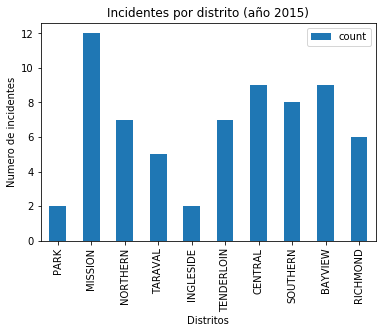

In [419]:
df = getCountByDistrict(conn, limit=10)
df.set_index(['district'])
graph = df.plot(kind='bar')
graph.set_xlabel("Distritos")
graph.set_ylabel("Numero de incidentes")
graph.set_title('Incidentes por distrito (año 2015)')
graph.set_xticklabels(df['district'])


* Representación de la frecuencia de delitos por zona/tipo de delito

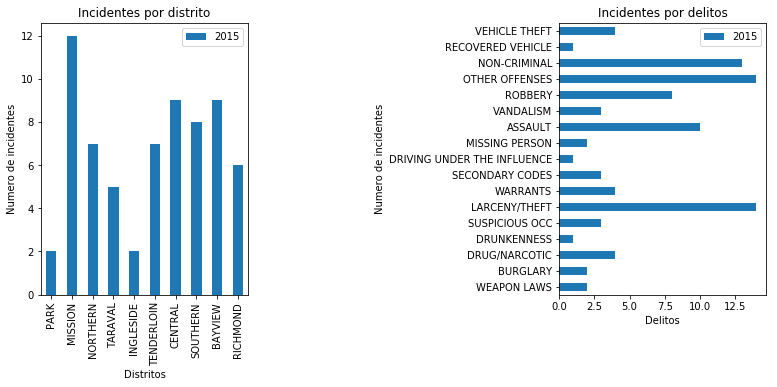

In [484]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 5
fig, (ax1, ax2) = plt.subplots(1, 2)


df = getCountByDistrict(conn, limit=10)
graph1 = df.plot(kind='bar', ax=ax1)
graph1.set_xlabel("Distritos")
graph1.set_ylabel("Numero de incidentes")
graph1.set_title('Incidentes por distrito')
graph1.set_xticklabels(df['district'])
ax1.legend(['2015','2016','2017'])

df = getCountByCategory(conn)[['category','count']]
graph2 = df.plot(kind='barh', ax=ax2)
graph2.set_xlabel("Delitos")
graph2.set_ylabel("Numero de incidentes")
graph2.set_title('Incidentes por delitos')
graph2.set_yticklabels(df['category'])
ax2.legend(['2015','2016','2017'])

fig.subplots_adjust(wspace=1.5)

Cerramos la conexión con la base de datos

In [485]:
conn.shutdown()


Álvaro López